#### Load Data

In [63]:
import pandas as pd
import numpy as np

In [64]:
# Load cleaned data
incomeDF  = pd.read_excel("NewCleanIncomeData.xlsx", sheet_name="Cleaned Data")
expenseDF = pd.read_excel("NewCleanProducionExpensesData.xlsx", sheet_name="Cleaned Data")

# Combine datasets
mergedDF = pd.concat([incomeDF, expenseDF], ignore_index=True)

#### Create Merged Data for Regression Model

In [65]:
# Ensure all year columns are numeric
year_columns = mergedDF.columns[1:]  # All except 'cat'
mergedDF[year_columns] = mergedDF[year_columns].apply(pd.to_numeric, errors='coerce')

# Set 'cat' as index, transpose to have years as rows
model_df = mergedDF.set_index("cat").T.rename_axis("year")

# Define target and predictors
predictors = [
    "property taxes and fees",
    "intermediate product expenses > pesticide",
    "intermediate product expenses > electricity",
    "intermediate product expenses > fertilizer, lime, and soil conditioner",
    "intermediate product expenses > seed",
    "labor expenses > cash labor",
]
target = "gross cash income"

# Filter final modeling DataFrame
model_df = model_df[predictors + [target]].dropna()
model_df.head()
# print(model_df.shape)

cat,property taxes and fees,intermediate product expenses > pesticide,intermediate product expenses > electricity,"intermediate product expenses > fertilizer, lime, and soil conditioner",intermediate product expenses > seed,labor expenses > cash labor,gross cash income
year,,,,,,,
1910,178810000.0,7000000.0,1000000.0,152000000.0,56000000.0,526000000.0,5.780000e+09
1911,196323000.0,7000000.0,1000000.0,168000000.0,65000000.0,530000000.0,5.584000e+09
1912,205733000.0,7000000.0,1000000.0,161000000.0,74000000.0,552000000.0,6.008000e+09
1913,233572000.0,7000000.0,1000000.0,175000000.0,62000000.0,569000000.0,6.238000e+09
1914,236911000.0,7000000.0,2000000.0,195000000.0,62000000.0,565000000.0,6.036000e+09


#### Log Transformations (for reference)

In [66]:
# ── Log-transform ─────────────────────────────────────

# for predictors, use log1p to safely handle any zeros
model_df[predictors] = np.log1p(model_df[predictors])

# for the target, use a straight log (assuming all > 0)
model_df[target] = np.log(model_df[target])

#### Spliting Data to Train and Test

In [75]:
from sklearn.model_selection import train_test_split

n = len(model_df)
train_size = int(n * 0.9)

train = model_df.iloc[:train_size]
test  = model_df.iloc[train_size:]

X_train, y_train = train[predictors], train[target]
X_test,  y_test  = test[predictors],  test[target]

# X_train.shape
# X_test.shape

#### Random Forest Regression

In [68]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [70]:
from sklearn.metrics import r2_score, mean_squared_error

y_pred = rf.predict(X_test)
r2   = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Test R²: {r2:.3f}")
print(f"Test RMSE: {rmse:,.0f}")

Test R²: -0.313
Test RMSE: 0


#### Comparison of Real Data & Predicted Data

In [49]:
# Compare the real data and predicted data
comparison = pd.DataFrame({
    "Actual": y_test,
    "Predicted": y_pred
}, index=y_test.index)
print(comparison)

            Actual     Predicted
year                            
2014  4.703030e+11  4.436005e+11
2015  4.226134e+11  4.361687e+11
2016  3.993532e+11  4.286679e+11
2017  4.131556e+11  4.273809e+11
2018  4.148467e+11  4.286679e+11
2019  4.264734e+11  4.271413e+11
2020  4.473560e+11  4.347957e+11
2021  5.006182e+11  4.433129e+11
2022  6.099657e+11  4.433129e+11
2023  5.829051e+11  4.433129e+11
2024  5.781526e+11  4.433129e+11
2025  6.093880e+11  4.433129e+11


#### Plot

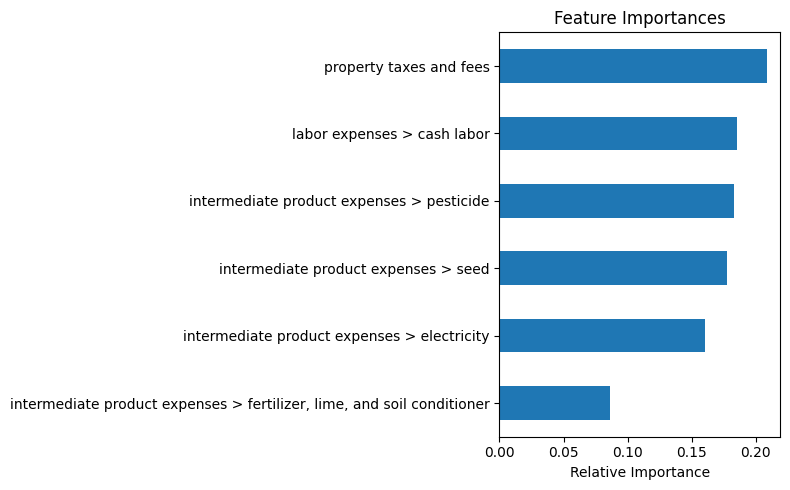

In [50]:
import matplotlib.pyplot as plt

fi = pd.Series(rf.feature_importances_, index=predictors).sort_values()
fi.plot(kind="barh", figsize=(8, 5))
plt.title("Feature Importances")
plt.xlabel("Relative Importance")
plt.tight_layout()
plt.show()

#### Random Forest without Split (for reference)

In [51]:
# Do not Split, use all data with Random Forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

X = model_df[predictors]
y = model_df[target]

# Testing R2
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)
y_pred = rf.predict(X)

r2 = r2_score(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))

print(f"R² (All data): {r2:.3f}")
print(f"RMSE (All data): {rmse:,.0f}")


R² (All data): 0.999
RMSE (All data): 4,152,497,095


#### Linear Regression without Split (for reference)

In [52]:
# Do not split, use all Data with Linear Regression
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X, y)
y_pred_lr = lr.predict(X)

r2_lr = r2_score(y, y_pred_lr)
print(f"Linear Regression R²: {r2_lr:.3f}")


Linear Regression R²: 0.997


#### Linear Regression with Split (for reference)

In [53]:
# Splitting data using Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Split as before
n = len(model_df)
train_size = int(n * 0.8)

train = model_df.iloc[:train_size]
test  = model_df.iloc[train_size:]

X_train, y_train = train[predictors], train[target]
X_test,  y_test  = test[predictors],  test[target]

# Linear Regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict and evaluate
y_pred = lr.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Linear Regression Test R²: {r2:.3f}")
print(f"Linear Regression Test RMSE: {rmse:,.0f}")

# print predictions
comparison = pd.DataFrame({
    "Actual": y_test,
    "Predicted": y_pred
}, index=y_test.index)
print("\nActual vs Predicted:\n", comparison)


Linear Regression Test R²: 0.922
Linear Regression Test RMSE: 31,079,845,016

Actual vs Predicted:
             Actual     Predicted
year                            
2002  2.201523e+11  2.424962e+11
2003  2.468211e+11  2.327658e+11
2004  2.665323e+11  2.437475e+11
2005  2.797129e+11  2.586170e+11
2006  2.732259e+11  2.788393e+11
2007  3.180271e+11  3.351563e+11
2008  3.493741e+11  3.614827e+11
2009  3.273772e+11  3.424633e+11
2010  3.536009e+11  3.433086e+11
2011  4.070346e+11  3.658935e+11
2012  4.512877e+11  4.016668e+11
2013  4.560800e+11  4.006052e+11
2014  4.703030e+11  4.348425e+11
2015  4.226134e+11  4.053708e+11
2016  3.993532e+11  3.881530e+11
2017  4.131556e+11  3.976091e+11
2018  4.148467e+11  4.058420e+11
2019  4.264734e+11  4.068749e+11
2020  4.473560e+11  4.278134e+11
2021  5.006182e+11  4.739452e+11
2022  6.099657e+11  5.227771e+11
2023  5.829051e+11  5.525063e+11
2024  5.781526e+11  5.745729e+11
2025  6.093880e+11  5.711066e+11
